The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss.
You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df=pd.read_csv('../data/raw/Task 3 and 4_Loan_Data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [4]:
df.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [5]:
default_rate = df['default'].mean()
print(f"Default rate: {default_rate:.2%}")


Default rate: 18.51%


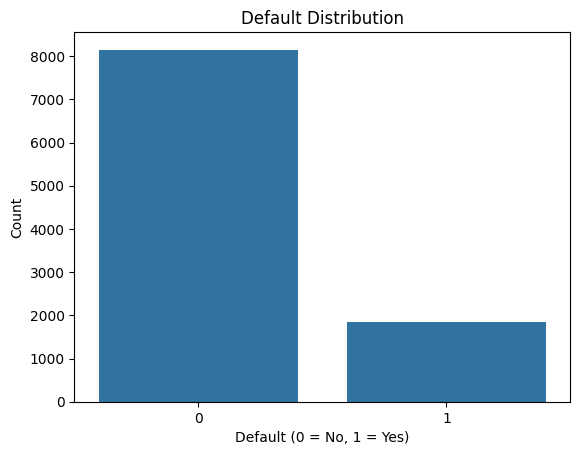

default
0    0.8149
1    0.1851
Name: proportion, dtype: float64


In [6]:
sns.countplot(x='default', data=df)
plt.title('Default Distribution')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

print(df['default'].value_counts(normalize=True))

In [16]:
X = df.drop(['customer_id', 'default'], axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train.value_counts(normalize=True)

default
0    0.814875
1    0.185125
Name: proportion, dtype: float64

imbalanced dataset 

In [17]:
smote=SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
y_resampled.value_counts(normalize=True)

default
1    0.5
0    0.5
Name: proportion, dtype: float64